In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.misc
from PIL import Image
import scipy.io
from matplotlib.pyplot import imshow

In [19]:
import tensorflow as tf

In [ ]:
vgg = scipy.io.loadmat("")
vgg_layers = vgg["layers"]

In [21]:
def weights(layer,expected_layer_name):
    W = vgg_layers[0][layer][0][0][0][0][0]
    b = vgg_layers[0][layer][0][0][0][0][1]
    layer_name = vgg_layers[0][layer][0][0][-2]
    assert layer_name == expected_layer_name
    return W,b

In [22]:
def conv2d(prev_layer,layer,layer_name):
    W,b = weights(layer,layer_name)
    W = tf.constant(W)
    b = tf.constant(np.reshape(b,(b.size)))
    return tf.nn.conv2d(prev_layer,filter=W,strides=[1,1,1,1],padding='SAME') + b

In [23]:
def relu(prev_layer):
    return tf.nn.relu(prev_layer)

In [24]:
def avg_pool(prev_layer):
    return tf.nn.avg_pool(prev_layer,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

In [ ]:
model = {}
model['input'] = tf.Variable(np.zeros((1,600,800,3)),dtype='float32')
model['conv1_1'] = relu(conv2d(model['input'],0,'conv1_1'))
model['conv1_2'] = relu(conv2d(model['conv1_1'],2,'conv1_2'))
model['avgpool1'] = avg_pool(model['conv1_2'])
model['conv2_1'] = relu(conv2d(model['avgpool1'],5,'conv2_1'))
model['conv2_2'] = relu(conv2d(model['conv2_2'],7,'conv2_2'))
model['avgpool2'] = avg_pool(model['conv2_2'])
model['conv3_1'] = relu(conv2d(model['avgpool2'],10,'conv3_1'))
model['conv3_2'] = relu(conv2d(model['conv3_1'],12,'conv3_2'))
model['conv3_3'] = relu(conv2d(model['conv3_2'],14,'conv3_3'))
model['conv3_4'] = relu(conv2d(model['conv3_2'],16,'conv3_4'))
model['avgpool3'] = avg_pool(model['conv3_4'])
model['conv4_1'] = relu(conv2d(model['avgpool3'],19,'conv4_1'))
model['conv4_2'] = relu(conv2d(model['conv4_1'],21,'conv4_2'))
model['conv4_3'] = relu(conv2d(model['conv4_2'],23,'conv4_3'))
model['conv4_4'] = relu(conv2d(model['conv4_3'],25,'conv4_4'))
model['avgpool4'] = avg_pool(model['conv4_4'])
model['conv_5_1'] = relu(conv2d(model['avgpool4'],28,'conv5_1'))
model['conv5_2'] = relu(conv2d(model['conv5_1'],30,'conv5_2'))
model['conv5_3'] = relu(conv2d(model['conv5_2'],32,'conv5_3'))
model['conv5_4'] = relu(conv2d(model['conv5_3'],34,'conv5_4'))
model['avgpool5'] = avg_pool(model['conv5_4'])

In [26]:
def content_loss(sess,model):
    
    def content_loss_util(p,q):
        N = p.shape[3]
        M = p.shape[1] * p.shape[2]
        return (1/(4 * N * M)) * tf.reduce_sum(tf.pow(q-p,2))
    
    return content_loss_util(sess.run(model['conv4_2']),sess.run(model['conv4_2']))

In [38]:
STYLE_LAYERS = [
    ('conv1_1', 0.5),
    ('conv2_1', 1.0),
    ('conv3_1', 1.5),
    ('conv4_1', 3.0),
    ('conv5_1', 4.0),
]

In [27]:
def style_loss(sess,model):
    
    def gram_mat(F,N,M):
        Ft = tf.reshape(F,(M,N))
        return tf.matmul(tf.transpose(Ft),Ft)
    
    def style_loss_util(p,q):
        N = p.shape[3]
        M = p.shape[1] * p.shape[2]
        A = gram_mat(p,N,M)
        B = gram_mat(q,N,M)
        return (1/(4 * N**2 * M**2)) * tf.reduce_sum(tf.pow(G-A,2))
        
    E = [style_loss_util(sess.run(model['layer_name']),sess.run(model[layer_name])) for layer_name,_ in STYLE_LAYERS]
    W = [w for _,w in STYLE_LAYERS]
    loss = sum([W[l] * E[l] for l in range(len(STYLE_LAYERS))])
    return loss

In [36]:
def generate_image(content_image,noise_ratio=0.6):
    noise_image = np.random.uniform(-20,20,(1,600,800,3)).astype('float32')
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    return input_image

In [39]:
MEAN_VALUES = np.array([123.68,116.779,103.939]).reshape((1,1,1,3))

In [44]:
def load_image(path):
    image = scipy.misc.imread(path)
    image = np.reshape(image,((1,) + image.shape))
    image = image - MEAN_VALUES
    return image

In [30]:
def save_image(path,image):
    image = imgae + MEAN_VALUES
    image = image[0]
    image = np.clip(image,0,255).astype('uint8')
    scipy.misc.imsave(path,image)

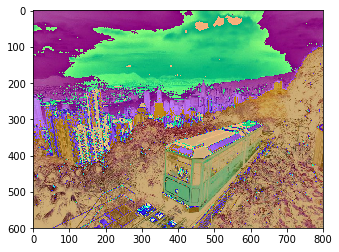

In [46]:
content_image = load_image('content.jpg')
imshow(content_image[0])

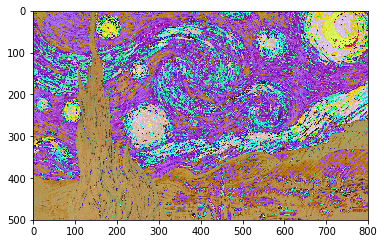

In [47]:
style_image = load_image('style.jpg')
imshow(style_image[0])

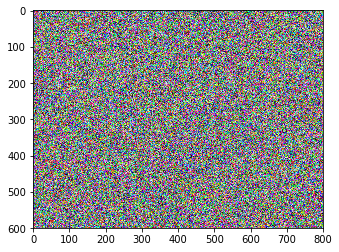

In [48]:
input_image = generate_image(content_image)
imshow(input_image[0])

In [ ]:
sess = tf.InteractiveSession()